# Librairies

In [2]:
import numpy as np
import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import combinations

# Data import

In [3]:
PATH_DATA = "../data/EuroMillions_numbers.csv"
df = pd.read_csv(PATH_DATA, sep=";")
df

,Date,N1,N2,N3,N4,N5,E1,E2,Winner,Gain
0,2004-12-24,3,27,29,4,37,6,5,1,10000000
1,2004-12-17,49,22,19,15,46,9,2,1,26215627
2,2004-11-26,24,1,34,4,36,8,6,1,43756502
3,2004-10-22,9,25,1,40,23,3,9,1,25059130
4,2004-01-10,48,20,45,21,12,6,5,1,29785269
...,...,...,...,...,...,...,...,...,...,...
1313,2021-01-15,4,10,27,38,40,3,11,0,56331898
1314,2021-12-01,2,10,18,34,35,6,9,0,41607178
1315,2021-08-01,18,23,37,41,42,4,6,0,30824040
1316,2021-05-01,12,34,37,38,42,1,3,0,17000000


# View data

On constate que dans notre dataset chaque combinaison gagnante est unique, autrement dit chaque combinaison n'est tombé qu'une seul fois.

In [4]:
df[["N1","N2","N3","N4","N5","E1","E2"]].value_counts()

N1  N2  N3  N4  N5  E1  E2
50  49  21  9   14  8   3     1
11  13  25  32  50  7   4     1
    14  29  6   19  3   1     1
    15  21  27  35  4   5     1
        35  41  50  5   8     1
                             ..
28  18  29  6   9   9   1     1
        40  27  35  3   5     1
    23  5   11  17  10  11    1
    25  5   11  16  7   9     1
1   2   5   21  32  2   12    1
Length: 1318, dtype: int64

On peut voir le nombre de fois que chaque nombre est tombé : 

<AxesSubplot:title={'center':"Récurence d'apparition des numéros sur le tirage gagant"}, xlabel='index', ylabel='0'>

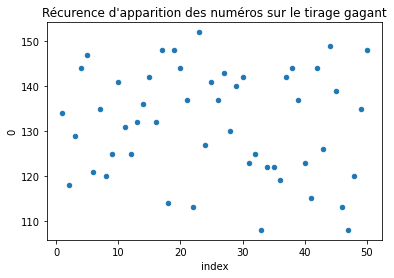

In [5]:
list_series = [df["N1"],df["N2"],df["N3"],df["N4"],df["N5"]]
s_rec = pd.concat(list_series).value_counts()
df_rec = s_rec.reset_index()
df_rec.plot(x="index",y=0,kind='scatter',title="Récurence d'apparition des numéros sur le tirage gagant")

De même avec les numéros étoiles

<AxesSubplot:title={'center':"Récurence d'apparition des numéros étoiles sur le tirage gagant"}, xlabel='index', ylabel='0'>

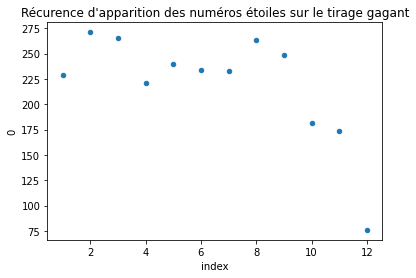

In [6]:
list_series = [df["E1"],df["E2"]]
s_rec_etoile = pd.concat(list_series).value_counts()
df_rec_etoile = s_rec_etoile.reset_index()
df_rec_etoile.plot(x="index",y=0,kind='scatter',title="Récurence d'apparition des numéros étoiles sur le tirage gagant")

Il ne semble pas y avoir de lien entre le tirage gagnant et les chiffre à première vue 

# Data augmentation

On ajoute une colonne "Ticket Gagnant" pour différencier les tirage gagnant des tirages perdant

In [7]:
df["Ticket Gagnant"] = 1

On augmente nos données pour obtenir un ration de 80% de tirage perdant pour 20% de tirage gagnant

In [8]:
def create_draws(df):
    np_df = df.to_numpy()
    possible_draw = list(combinations(range(1,51),5))
    possible_draw_star = list(combinations(range(1,13),2))
    nb_draw = 4
    add_raws = []
    for winner_draw in np_df:
        list_star_draw = random.sample(possible_draw_star,k=nb_draw+1)
        list_draw = random.sample(possible_draw,k=nb_draw+1)
        new_draws = []
        for i in range(nb_draw+1):
            np_possible_draw = np.array(list_draw[i])
            np_possible_draw_star = np.array(list_star_draw[i])
            if not (((np_possible_draw) == sorted(winner_draw[1:6])).all() and (np_possible_draw_star == sorted(winner_draw[6:8])).all()):
                possible_draw_rd = random.sample(list_draw[i],k=5)
                possible_draw_star_rd = random.sample(list_star_draw[i],k=2)
                new_draw = [winner_draw[0], *possible_draw_rd, *possible_draw_star_rd, *winner_draw[8:10], 0]
                new_draws.append(new_draw)
        if len(new_draws) > nb_draw:
            new_draws.pop(0)
        add_raws += new_draws
    l_df = np_df.tolist() + add_raws
    return pd.DataFrame(l_df, columns=df.columns)

df_aug = create_draws(df)

In [9]:
df_aug = df_aug.sort_values(by="Date")
df_aug = df_aug.set_index([df_aug["Date"],df_aug.index])
df_aug = df_aug.drop(columns=["Date"])
df_aug

N1  N2  N3  N4  N5  E1  E2  Winner      Gain  Ticket Gagnant
Date                                                                         
2004-01-10 1337  21  47   1  24  35  12   1       1  29785269               0
           4     48  20  45  21  12   6   5       1  29785269               1
           1336   6  13   7  38  24   1   8       1  29785269               0
           1335  48  13  20   1   5  12  11       1  29785269               0
           1334  34  48  27  44  36  10   6       1  29785269               0
...              ..  ..  ..  ..  ..  ..  ..     ...       ...             ...
2021-12-01 6577  11  20  26  41   7   6   2       0  41607178               0
           6576  40  39  33  29  45   4   1       0  41607178               0
           6575   1  29   5  20  48  10   3       0  41607178               0
           6574  39  47  19  16  49   8  11       0  41607178               0
           1314   2  10  18  34  35   6   9       0  41607178               1

[6590 rows x 10 columns]

On ajoute des features potentiellement explicativent 

In [10]:
def change2bool(df):
    np_df = df.sort_values(by="Date").to_numpy()
    
    arr_N_E_bool = np.zeros((df.shape[0],50+12))
    for i in range(np_df.shape[0]):
        N_E_bool = np.zeros(50+12, dtype=np.int)
        index = np.add(np_df[i,1:6],-1)
        index = np.array(index,dtype=int)
        N_E_bool[index] = 1
        index = np.add(np_df[i,6:8],-1+50)
        index = np.array(index,dtype=int)
        N_E_bool[index] = 1
        arr_N_E_bool[i] = N_E_bool
    columns = list(range(1,50+12+1))
    df_N_E_bool = pd.DataFrame(arr_N_E_bool,columns=columns)
    return df_N_E_bool

def change2count(df):
    np_df = df.to_numpy()
    
    N_E_compteur = np.zeros(50+12, dtype=np.int)
    arr_N_E_compteur = np.zeros((df.shape[0],50+12))
    for i in range(np_df.shape[0]):
        index = np.add(np_df[i][1:6],-1)
        index = np.array(index,dtype=int)
        N_E_compteur[index] += 1
        index = np.add(np_df[i][6:8],-1+50)
        index = np.array(index,dtype=int)
        N_E_compteur[index] += 1
        N_min = np.amin(N_E_compteur[:50])
        E_min = np.amin(N_E_compteur[50:])
        N_compteur = np.subtract(N_E_compteur[:50],N_min,dtype=int)
        E_compteur = np.subtract(N_E_compteur[50:],E_min,dtype=int)
        arr_N_E_compteur[i,:50] = N_compteur
        arr_N_E_compteur[i,50:] = E_compteur
        
    columns = list(range(1,50+12+1))
    df_N_E_compteur = pd.DataFrame(arr_N_E_compteur,columns=columns,index=pd.MultiIndex.from_arrays([df["Date"],df.index],names=["Date","Index"]))
    return df_N_E_compteur

df = df.sort_values(by="Date")
df_bool = change2bool(df)
df_count = change2count(df)
df_count


,,1,2,3,4,5,6,7,8,9,10,...,53,54,55,56,57,58,59,60,61,62
Date,Index,,,,,,,,,,,,,,,,,,,,,
2004-01-10,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-02-13,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2004-04-06,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0
2004-05-03,11,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0
2004-05-14,9,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29,1309,26.0,9.0,21.0,36.0,39.0,13.0,27.0,12.0,17.0,32.0,...,189.0,145.0,165.0,157.0,158.0,188.0,172.0,106.0,99.0,0.0
2021-02-02,1308,26.0,9.0,21.0,36.0,39.0,13.0,27.0,12.0,17.0,32.0,...,188.0,144.0,164.0,156.0,157.0,187.0,172.0,105.0,98.0,0.0
2021-05-01,1316,26.0,9.0,21.0,36.0,39.0,13.0,27.0,12.0,17.0,32.0,...,189.0,144.0,164.0,156.0,157.0,187.0,172.0,105.0,98.0,0.0


# Répartition des données en train et test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_count = pd.DataFrame(MinMaxScaler().fit_transform(df_count), columns=df_count.columns)
X = df_count.iloc[:-1]
y = df_bool.iloc[1:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=0)

# Random Forest

In [161]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0,)
clf.fit(X_train, y_train)

62

In [157]:
y_pred_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
y_pred[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
def find_best_draw(y_prob:np.ndarray):
    N_index = np.argpartition(y_prob[:50], -5)[-5:]
    E_index = np.argpartition(y_prob[-12:], -2)[-2:]
    index = np.array([*N_index, *E_index],dtype=int)
    draw = index + 1
    return draw

In [56]:
def find_proba(y_prob:np.ndarray):
    y_prob[:50] = np.divide(y_prob[:50],np.sum(y_prob[:50]))
    y_prob[50:] = np.divide(y_prob[50:],np.sum(y_prob[50:]))
    N_index = np.argpartition(y_prob[:50], -5)[-5:]
    E_index = np.argpartition(y_prob[-12:], -2)[-2:]
    index = np.array([*N_index, *E_index + 50], dtype=int)
    win_proba = np.prod(y_prob[index])
    return win_proba

In [67]:
def own_y_pred(y_pred_prob:np.ndarray):
    y_pred = np.zeros((y_pred_prob.shape[1],y_pred_prob.shape[0]))
    for i in range(y_pred_prob.shape[1]):
        y_prob = y_pred_prob[:,i,1]
        draw = find_best_draw(y_prob)
        index = draw - 1
        index[-2:] += 50
        y_pred[i,index] = 1
    return y_pred

In [122]:
np_y_pred_prob = np.array(y_pred_prob)
custom_y_pred = own_y_pred(np_y_pred_prob)

In [95]:
def own_accuracy_score(y_test: np.ndarray, y_pred: np.ndarray, normalize: bool = True)->float:
    score = 0
    for i in range(y_test.shape[0]):
        if (y_test == y_pred).all():
            score += 1
    if normalize:
        score /= y_pred.shape[0]
    return score

In [143]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, recall_score, precision_score
np_y_test = y_test#.to_numpy()

res = np.zeros((2,4))
res[0,0] = accuracy_score(np_y_test,y_pred)
res[1,0] = accuracy_score(np_y_test,custom_y_pred)
#multilabel_confusion_matrix(np_y_test,custom_y_pred)
res[1,1] = recall_score(np_y_test, custom_y_pred, average="weighted")
res[0,1] = recall_score(np_y_test, y_pred, average="weighted")
res[1,2] = precision_score(np_y_test, custom_y_pred, average="weighted")
res[0,2] = precision_score(np_y_test, y_pred, average="weighted")
res[1,3] = f1_score(np_y_test,custom_y_pred,average="weighted")
res[0,3] = f1_score(np_y_test,y_pred,average="weighted")
res.T

array([[0.        , 0.        ],
       [0.05465368, 0.129329  ],
       [0.13596139, 0.1302645 ],
       [0.07563902, 0.12802987]])

# Enregistrement du modèle 

In [15]:
import pickle

def save_model(clf):
   file_name = "../app/models/model.pkl"
   if os.path.exists(file_name):
      os.remove(file_name) 
   with open(file_name, 'wb') as f:
      pickle.dump(clf,file=f)
   return 0
